# CCA: Canonical Correlation Analysis

In [ ]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

In [5]:
#load the SST anomalies (processed data from last tutorial)
calcofi_data = pd.read_csv('Datasets/calcofi_combined.csv')
calcofi_data = calcofi_data.dropna(subset=['T_degC'])

# Calculate the percentage of NaN values per column, formatted to 2 decimals and in percentage format
na_percentage = (calcofi_data.isna().mean() * 100).round(2)

# Display the results in percentage format
na_percentage = na_percentage.apply(lambda x: f"{x:.2f}%")

# Print the results
print('Missing Values per Column (in %)')
print(na_percentage)

Missing Values per Column (in %)
Cst_Cnt         0.00%
Sta_ID          0.00%
ChlorA          0.00%
Phaeop          0.00%
T_degC          0.00%
Salnty          0.56%
O2ml_L          0.61%
PO4uM           4.39%
SiO3uM          3.95%
NO3uM           4.06%
Depthm          0.00%
Date            0.00%
Year            0.00%
Month           0.00%
Julian_Day      0.00%
Lat_Dec         0.00%
Lon_Dec         0.00%
Julian_Date     0.00%
Wind_Spd        2.24%
Wave_Ht        43.42%
Dry_T           2.14%
Wave_Prd       44.11%
Barometer       2.18%
dtype: object


In [ ]:
# Extract characters from position 7 to 10 of the Sta_ID column
calcofi_data['Sta_ID_prefix'] = calcofi_data['Sta_ID'].astype(str).str[6:9]

# Count unique values in the extracted prefixes
unique_sta_id_prefix_count = calcofi_data['Sta_ID_prefix'].nunique()

# Print the count of unique values based on the extracted digits
print("Count of unique Station values based on the extracted 3 digits (positions 7 to 10):", unique_sta_id_prefix_count)

Count of unique Sta_ID values based on the extracted 3 digits (positions 7 to 10): 103


In [32]:
# Create 3 datasets from calcofi_data

# Create the cal_data dataset
cal_data = calcofi_data[['Date', 'Sta_ID_prefix', 'ChlorA']]

# Create the temp_data dataset
temp_data = calcofi_data[['Date', 'Sta_ID_prefix', 'T_degC']]

# Create the depth_data dataset
depth_data = calcofi_data[['Date', 'Sta_ID_prefix', 'Depthm']]


In [34]:
cal_data.head()

,Date,Sta_ID_prefix,ChlorA
0,1973-03-08,035,0.650000
1,1973-03-10,008,2.483333
2,1973-03-10,008,0.240000
3,1973-03-11,010,2.425000
4,1973-03-12,009,5.540909


/var/folders/pp/y5y2qg9j3hj_2v8_lfh8f_n40000gn/T/ipykernel_46992/2426582485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal_data['Date'] = pd.to_datetime(cal_data['Date'], errors='coerce')


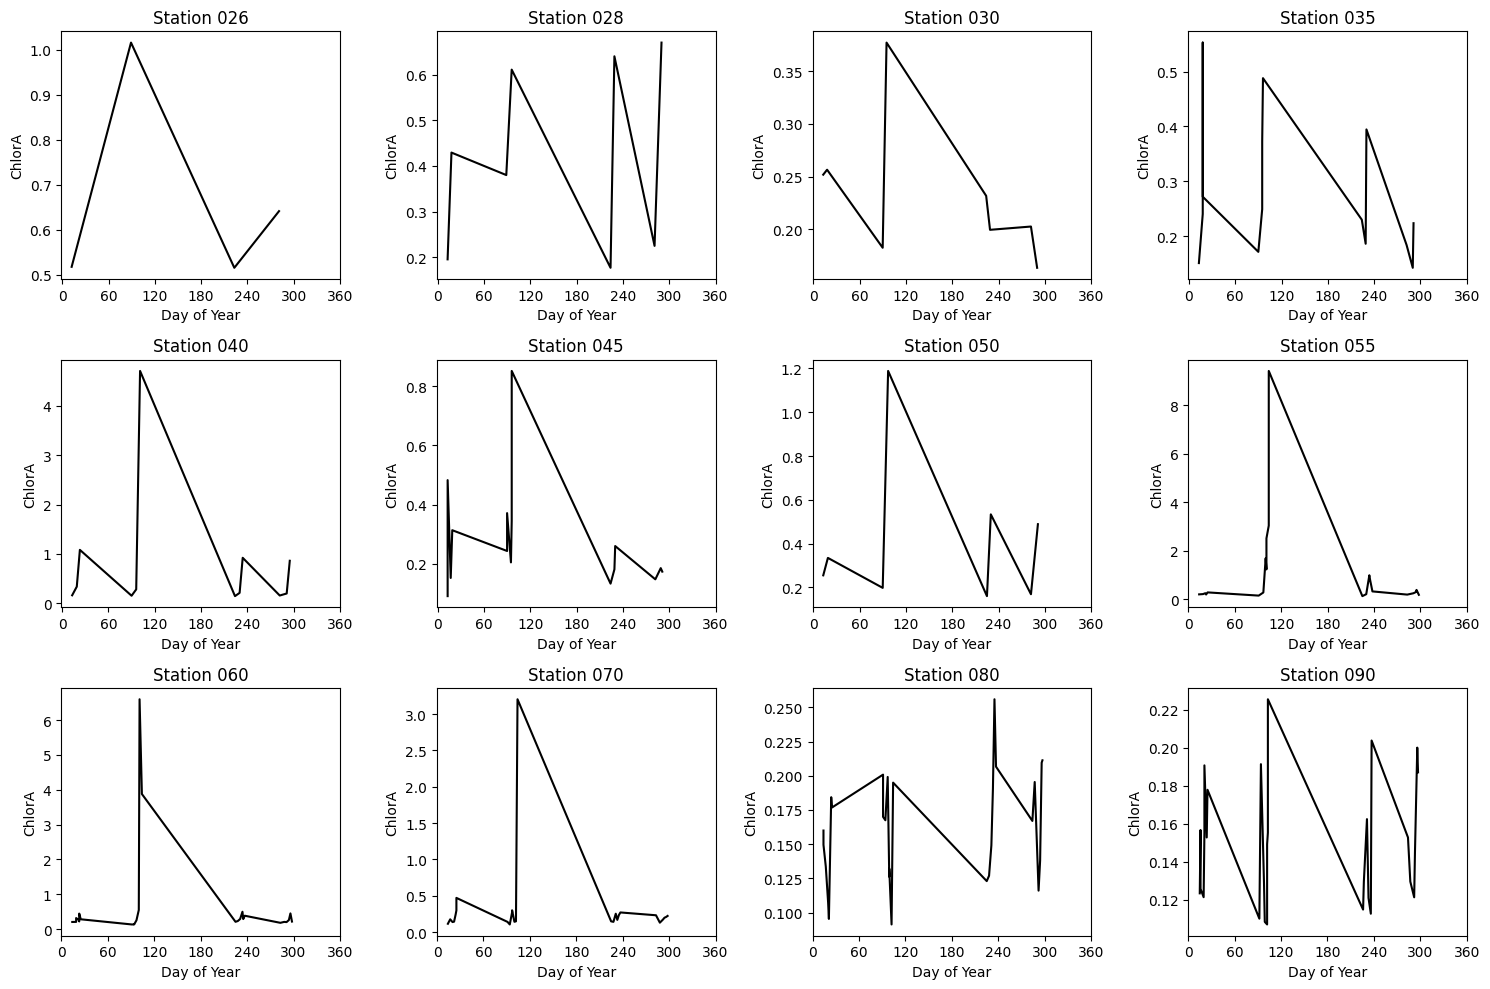

In [40]:
# Ensure the Date column is properly converted to datetime format
cal_data['Date'] = pd.to_datetime(cal_data['Date'], errors='coerce')

# Check for any non-datetime values that were converted to NaT
if cal_data['Date'].isna().any():
    print("Warning: There are invalid dates in the Date column. They have been converted to NaT.")

# Filter cal_data for entries from the year 1993
cal_data_1993 = cal_data[cal_data['Date'].dt.year == 1993]

# Select the first 12 unique stations that have data in 1993
first_12_stations = cal_data_1993['Sta_ID_prefix'].unique()[:12]
data_first_12_stations = cal_data_1993[cal_data_1993['Sta_ID_prefix'].isin(first_12_stations)]

# Create the plot
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()

# Plot ChlorA data for each of the first 12 stations
for i, station in enumerate(first_12_stations):
    station_data = data_first_12_stations[data_first_12_stations['Sta_ID_prefix'] == station]
    
    # Verify there is data to plot for the station
    if not station_data.empty:
        # Use .assign() to avoid the warning
        station_data = station_data.assign(DayOfYear=station_data['Date'].dt.dayofyear)
        ax[i].plot(station_data['DayOfYear'], station_data['ChlorA'], c="k")
        ax[i].set_title(f"Station {station}")
        ax[i].set_xlabel("Day of Year")
        ax[i].set_ylabel("ChlorA")
        ax[i].set_xticks(range(0, 366, 60))  # Set intervals for every 60 days for longer spacing
    
plt.tight_layout()
plt.show()

/var/folders/pp/y5y2qg9j3hj_2v8_lfh8f_n40000gn/T/ipykernel_46992/2982757526.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['Date'] = pd.to_datetime(temp_data['Date'], errors='coerce')


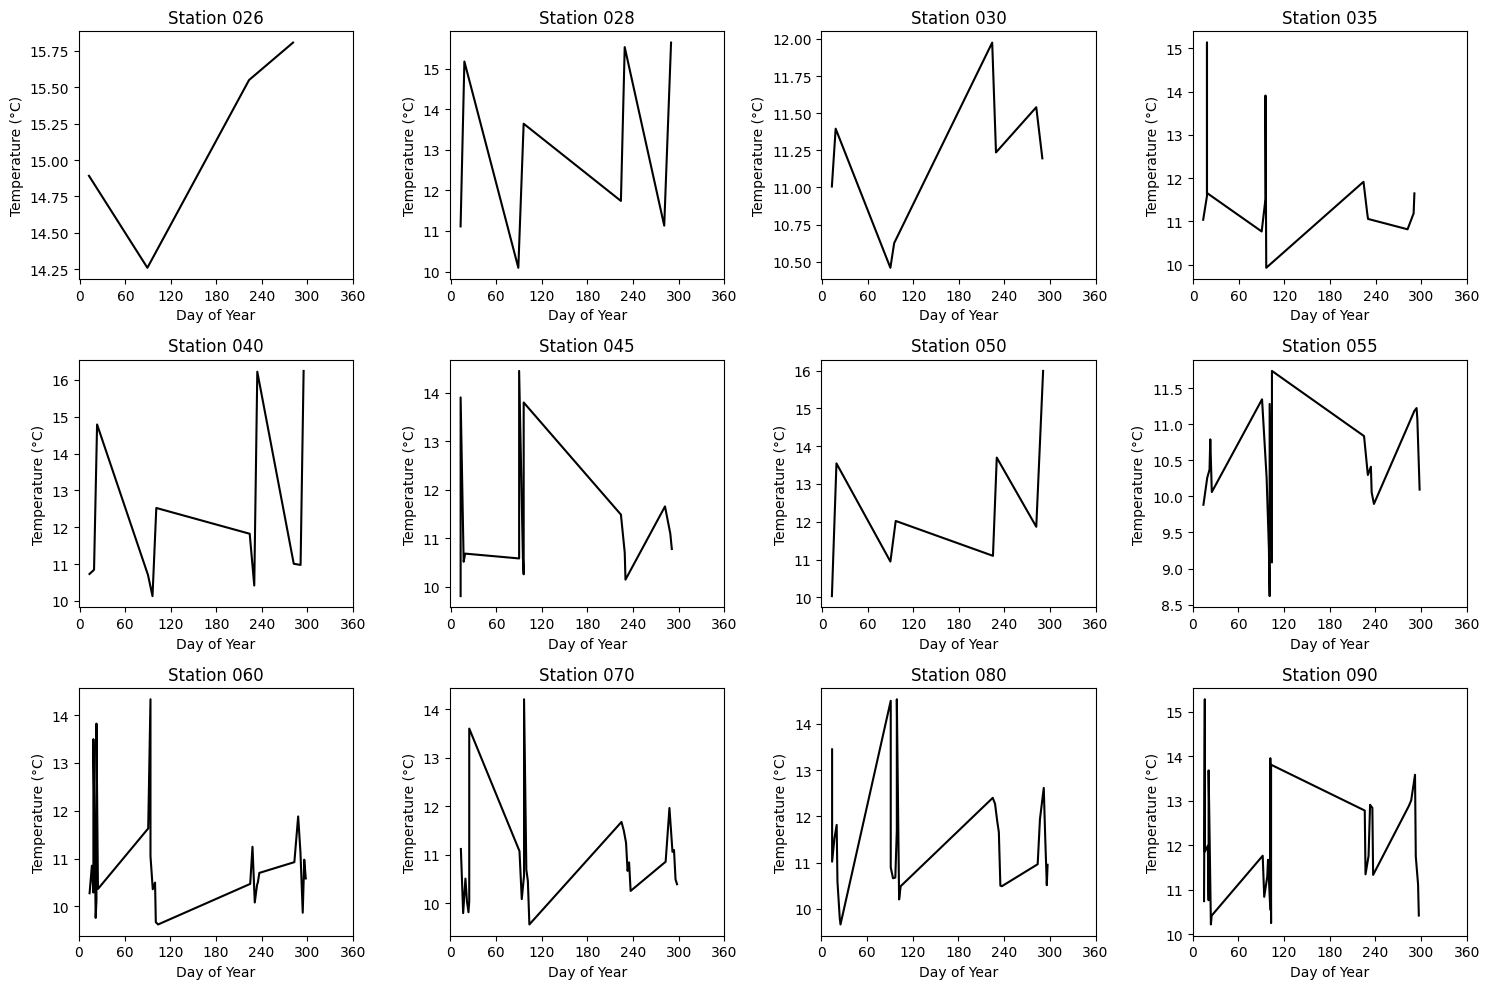

In [ ]:
# Ensure the Date column is properly converted to datetime format
temp_data['Date'] = pd.to_datetime(temp_data['Date'], errors='coerce')

# Check for any non-datetime values that were converted to NaT
if temp_data['Date'].isna().any():
    print("Warning: There are invalid dates in the Date column. They have been converted to NaT.")

# Filter temp_data for entries from the year 1993
temp_data_1993 = temp_data[temp_data['Date'].dt.year == 1993]

# Select the first 12 unique stations that have data in 1993
first_12_stations = temp_data_1993['Sta_ID_prefix'].unique()[:12]
data_first_12_stations = temp_data_1993[temp_data_1993['Sta_ID_prefix'].isin(first_12_stations)]

# Create the plot
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()

# Plot T_degC data for each of the first 12 stations
for i, station in enumerate(first_12_stations):
    station_data = data_first_12_stations[data_first_12_stations['Sta_ID_prefix'] == station]
    
    # Verify there is data to plot for the station
    if not station_data.empty:
        # Use .assign() to avoid the warning
        station_data = station_data.assign(DayOfYear=station_data['Date'].dt.dayofyear)
        ax[i].plot(station_data['DayOfYear'], station_data['T_degC'], c="k")
        ax[i].set_title(f"Station {station}")
        ax[i].set_xlabel("Day of Year")
        ax[i].set_ylabel("Temperature (°C)")
        ax[i].set_xticks(range(0, 366, 60))  # Set intervals for every 60 days for longer spacing
    
plt.tight_layout()
plt.show()

/var/folders/pp/y5y2qg9j3hj_2v8_lfh8f_n40000gn/T/ipykernel_46992/2356021056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depth_data['Date'] = pd.to_datetime(depth_data['Date'], errors='coerce')


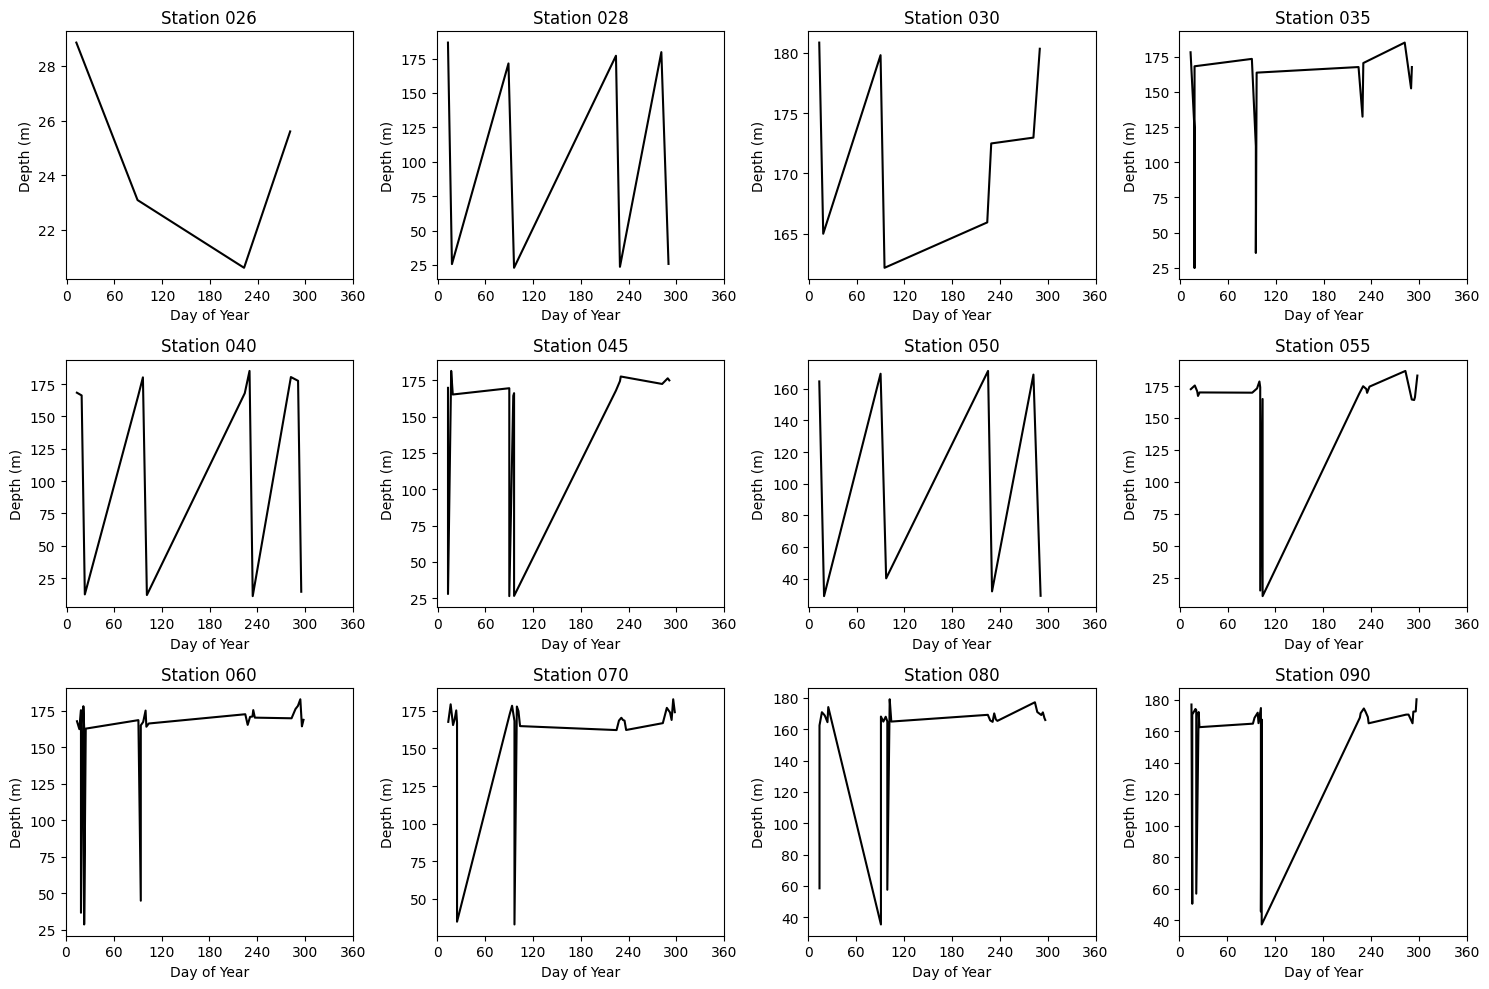

In [45]:
# Ensure the Date column is properly converted to datetime format
depth_data['Date'] = pd.to_datetime(depth_data['Date'], errors='coerce')

# Check for any non-datetime values that were converted to NaT
if depth_data['Date'].isna().any():
    print("Warning: There are invalid dates in the Date column. They have been converted to NaT.")

# Filter depth_data for entries from the year 1993
depth_data_1993 = depth_data[depth_data['Date'].dt.year == 1993]

# Select the first 12 unique stations that have data in 1993
first_12_stations = depth_data_1993['Sta_ID_prefix'].unique()[:12]
data_first_12_stations = depth_data_1993[depth_data_1993['Sta_ID_prefix'].isin(first_12_stations)]

# Create the plot
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()

# Plot Depthm data for each of the first 12 stations
for i, station in enumerate(first_12_stations):
    station_data = data_first_12_stations[data_first_12_stations['Sta_ID_prefix'] == station]
    
    # Verify there is data to plot for the station
    if not station_data.empty:
        # Use .assign() to avoid the warning
        station_data = station_data.assign(DayOfYear=station_data['Date'].dt.dayofyear)
        ax[i].plot(station_data['DayOfYear'], station_data['Depthm'], c="k")
        ax[i].set_title(f"Station {station}")
        ax[i].set_xlabel("Day of Year")
        ax[i].set_ylabel("Depth (m)")
        ax[i].set_xticks(range(0, 366, 60))  # Set intervals for every 60 days for longer spacing
    
plt.tight_layout()
plt.show()

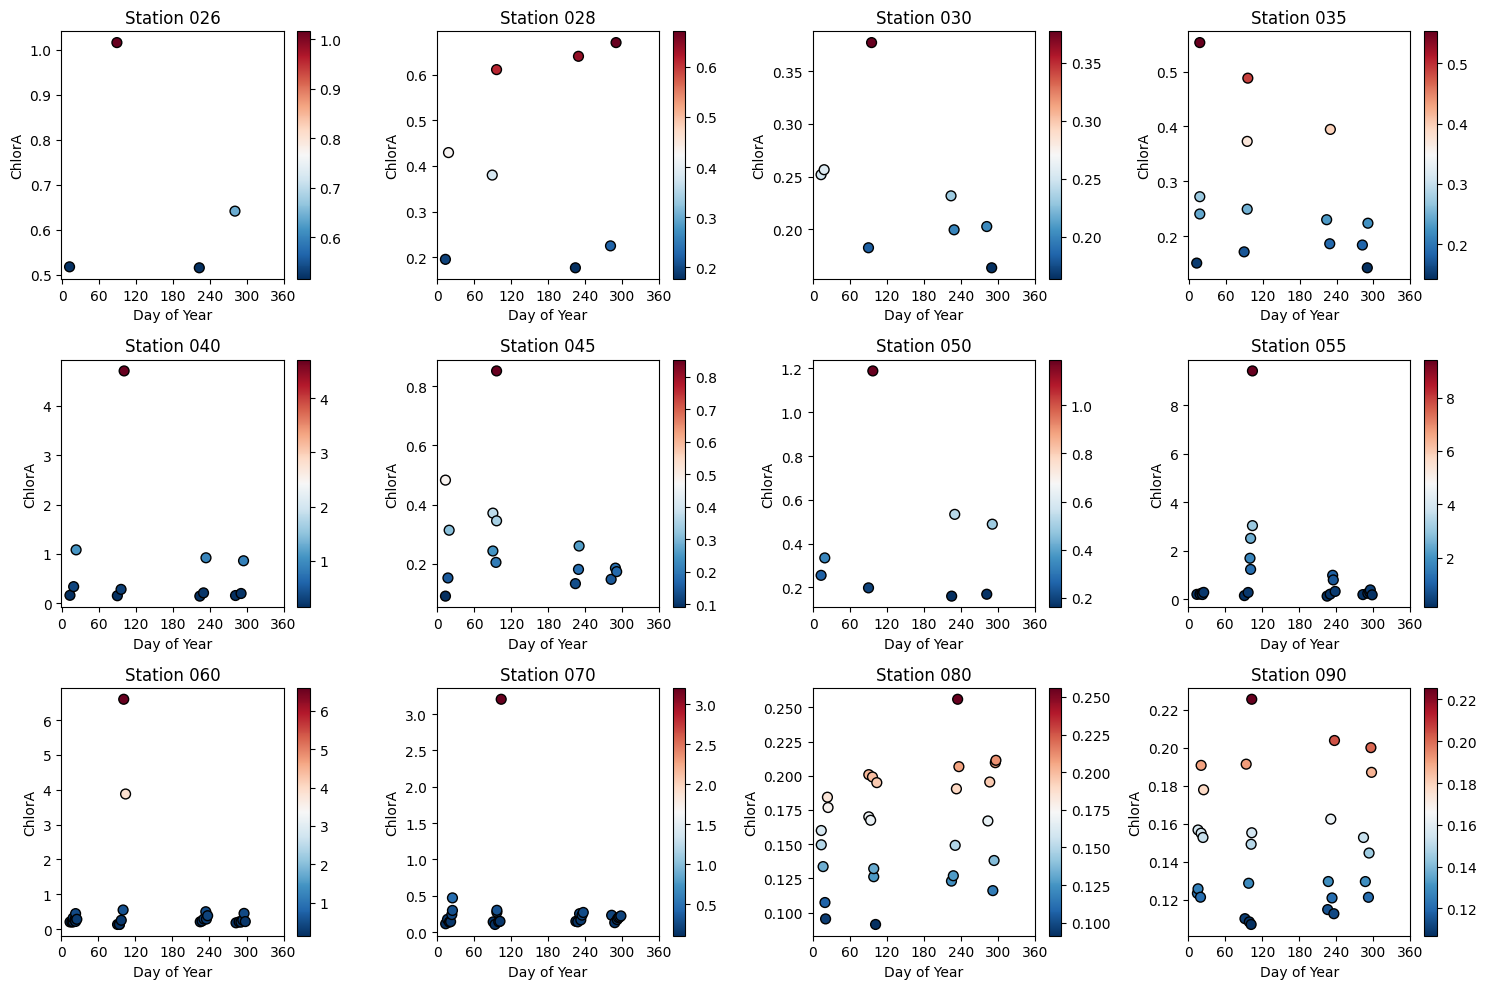

In [47]:
# Create the scatter plots for each station to see the ChlorA impact over time
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()

# Plot ChlorA data for each of the first 12 stations
for i, station in enumerate(first_12_stations):
    station_data = data_first_12_stations[data_first_12_stations['Sta_ID_prefix'] == station]
    
    # Verify there is data to plot for the station
    if not station_data.empty:
        station_data = station_data.sort_values(by='Date')  # Ensure data is sorted by Date
        ax[i].scatter(
            station_data['Date'].dt.dayofyear,  # Day of the year as x-axis
            station_data['ChlorA'],             # ChlorA values as y-axis
            c=station_data['ChlorA'],           # Color based on ChlorA values
            s=50,                               # Size of the points
            cmap="RdBu_r",                      # Color map
            edgecolors="k"
        )
        ax[i].set_title(f"Station {station}")
        ax[i].set_xlabel("Day of Year")
        ax[i].set_ylabel("ChlorA")
        ax[i].set_xticks(range(0, 366, 60))  # Set intervals for every 60 days for longer spacing
        plt.colorbar(ax[i].collections[0], ax=ax[i], orientation='vertical')

plt.tight_layout()
plt.show()

In [56]:
# Reduce the Date to month-year format and take the average for each month
cal_data['MonthYear'] = cal_data['Date'].dt.to_period('M')
temp_data['MonthYear'] = temp_data['Date'].dt.to_period('M')
depth_data['MonthYear'] = depth_data['Date'].dt.to_period('M')

# Group by MonthYear and Sta_ID_prefix, then average the data
cal_data = cal_data.groupby(['MonthYear', 'Sta_ID_prefix']).mean().reset_index()
temp_data = temp_data.groupby(['MonthYear', 'Sta_ID_prefix']).mean().reset_index()
depth_data = depth_data.groupby(['MonthYear', 'Sta_ID_prefix']).mean().reset_index()

# Pivot the datasets with MonthYear as the index
cal_data_pivot = cal_data.pivot(index='MonthYear', columns='Sta_ID_prefix', values='ChlorA')
temp_data_pivot = temp_data.pivot(index='MonthYear', columns='Sta_ID_prefix', values='T_degC')
depth_data_pivot = depth_data.pivot(index='MonthYear', columns='Sta_ID_prefix', values='Depthm')

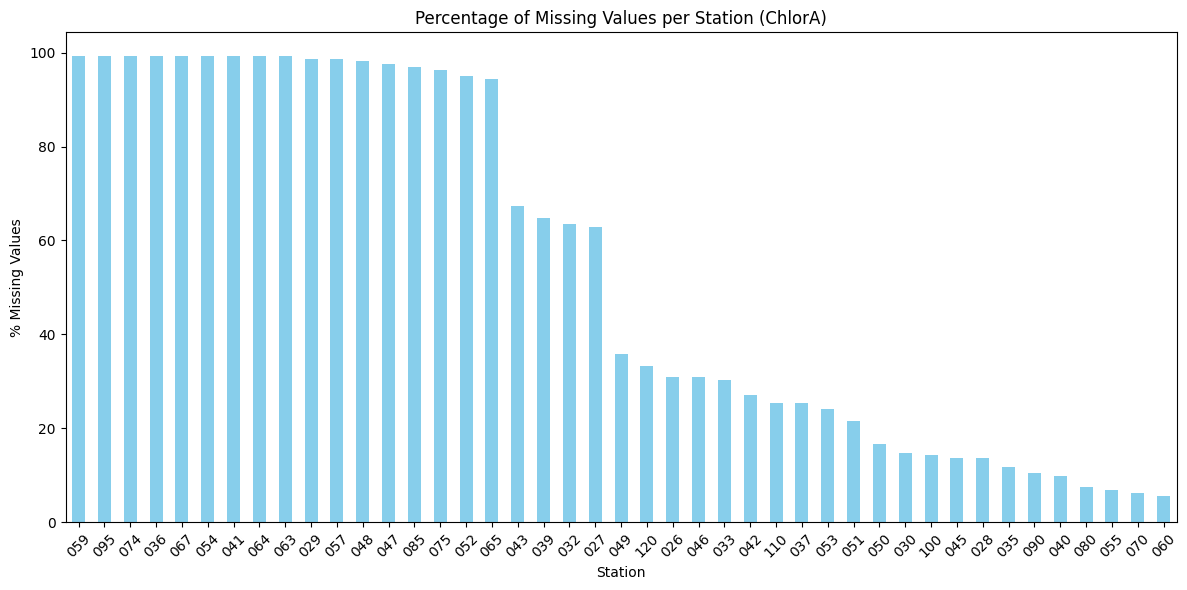

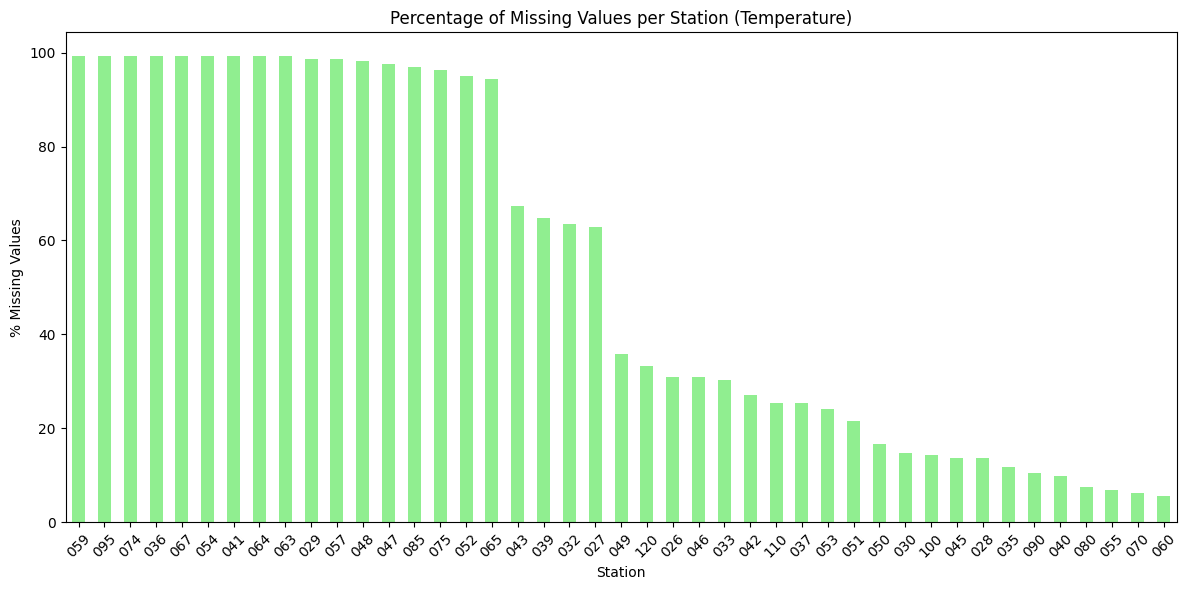

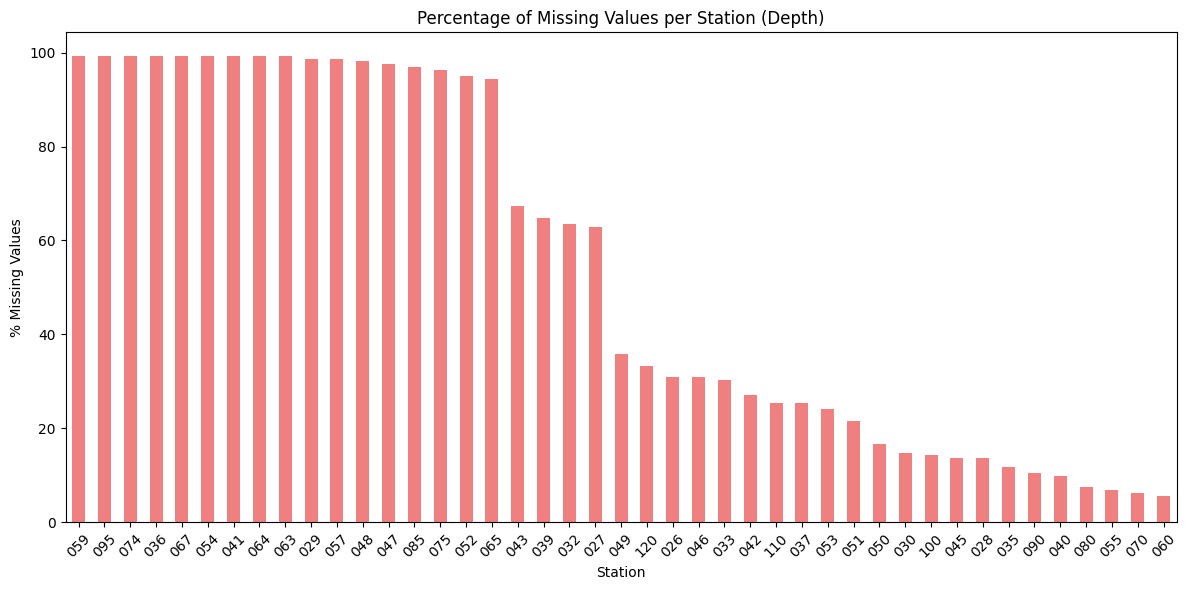

In [ ]:
# Calculate the percentage of missing values per station for each dataset
cal_data_missing = cal_data_pivot.isnull().mean() * 100
temp_data_missing = temp_data_pivot.isnull().mean() * 100
depth_data_missing = depth_data_pivot.isnull().mean() * 100

# Sort the missing values from max to min for each dataset
cal_data_missing_sorted = cal_data_missing.sort_values(ascending=False)
temp_data_missing_sorted = temp_data_missing.sort_values(ascending=False)
depth_data_missing_sorted = depth_data_missing.sort_values(ascending=False)

# Plot for cal_data
plt.figure(figsize=(12, 6))
cal_data_missing_sorted.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values per Station (ChlorA)')
plt.xlabel('Station')
plt.ylabel('% Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for temp_data
plt.figure(figsize=(12, 6))
temp_data_missing_sorted.plot(kind='bar', color='lightgreen')
plt.title('Percentage of Missing Values per Station (Temperature)')
plt.xlabel('Station')
plt.ylabel('% Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for depth_data
plt.figure(figsize=(12, 6))
depth_data_missing_sorted.plot(kind='bar', color='lightcoral')
plt.title('Percentage of Missing Values per Station (Depth)')
plt.xlabel('Station')
plt.ylabel('% Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
# Threshold for removing stations
threshold = 40  # 40% missing values

# Identify stations to keep (those with <= 40% missing values)
stations_to_keep_cal = cal_data_missing[cal_data_missing <= threshold].index
stations_to_keep_temp = temp_data_missing[temp_data_missing <= threshold].index
stations_to_keep_depth = depth_data_missing[depth_data_missing <= threshold].index

# Filter the pivoted DataFrames to keep only these stations
cal_data_pivot = cal_data_pivot[stations_to_keep_cal]
temp_data_pivot = temp_data_pivot[stations_to_keep_temp]
depth_data_pivot = depth_data_pivot[stations_to_keep_depth]

# Drop rows with missing values in the remaining data
cal_data_pivot = cal_data_pivot.dropna()
temp_data_pivot = temp_data_pivot.dropna()
depth_data_pivot = depth_data_pivot.dropna()

In [73]:
cal_data_pivot.tail()

Sta_ID_prefix,026,028,030,033,035,037,040,042,045,046,...,051,053,055,060,070,080,090,100,110,120
MonthYear,,,,,,,,,,,,,,,,,,,,,
2019-07-01,2.699357,0.743043,0.628897,1.244125,0.427954,0.262111,1.112095,1.057071,0.394214,1.047700,...,2.516597,0.760474,1.141202,0.481993,0.356380,0.202892,0.152443,0.146471,0.117906,0.118095
2019-11-01,1.459089,0.599906,0.394778,0.864375,0.422465,0.240000,0.636642,0.496800,0.274980,0.554333,...,0.827602,0.196762,0.308045,0.272451,0.295149,0.300766,0.181720,0.152316,0.143968,0.126481
2020-01-01,1.216333,0.165215,0.266589,0.138625,0.155583,0.070278,0.337857,0.401615,0.227556,0.285529,...,1.001752,0.618550,0.631997,0.456698,0.358941,0.280043,0.220164,0.178323,0.113955,0.117554
2020-07-01,3.384181,1.199042,1.802587,1.713833,1.558687,0.411421,1.006447,3.727133,0.906757,1.636789,...,1.651506,0.800952,0.707398,0.416712,0.228521,0.214866,0.154124,0.129112,0.151250,0.129819
2020-10-01,0.947500,0.505938,0.832756,0.631444,0.459057,0.380533,0.433849,0.425714,0.316648,0.409706,...,0.782763,0.184312,0.231036,0.188489,0.220897,0.149150,0.144500,0.152594,0.135422,0.130043


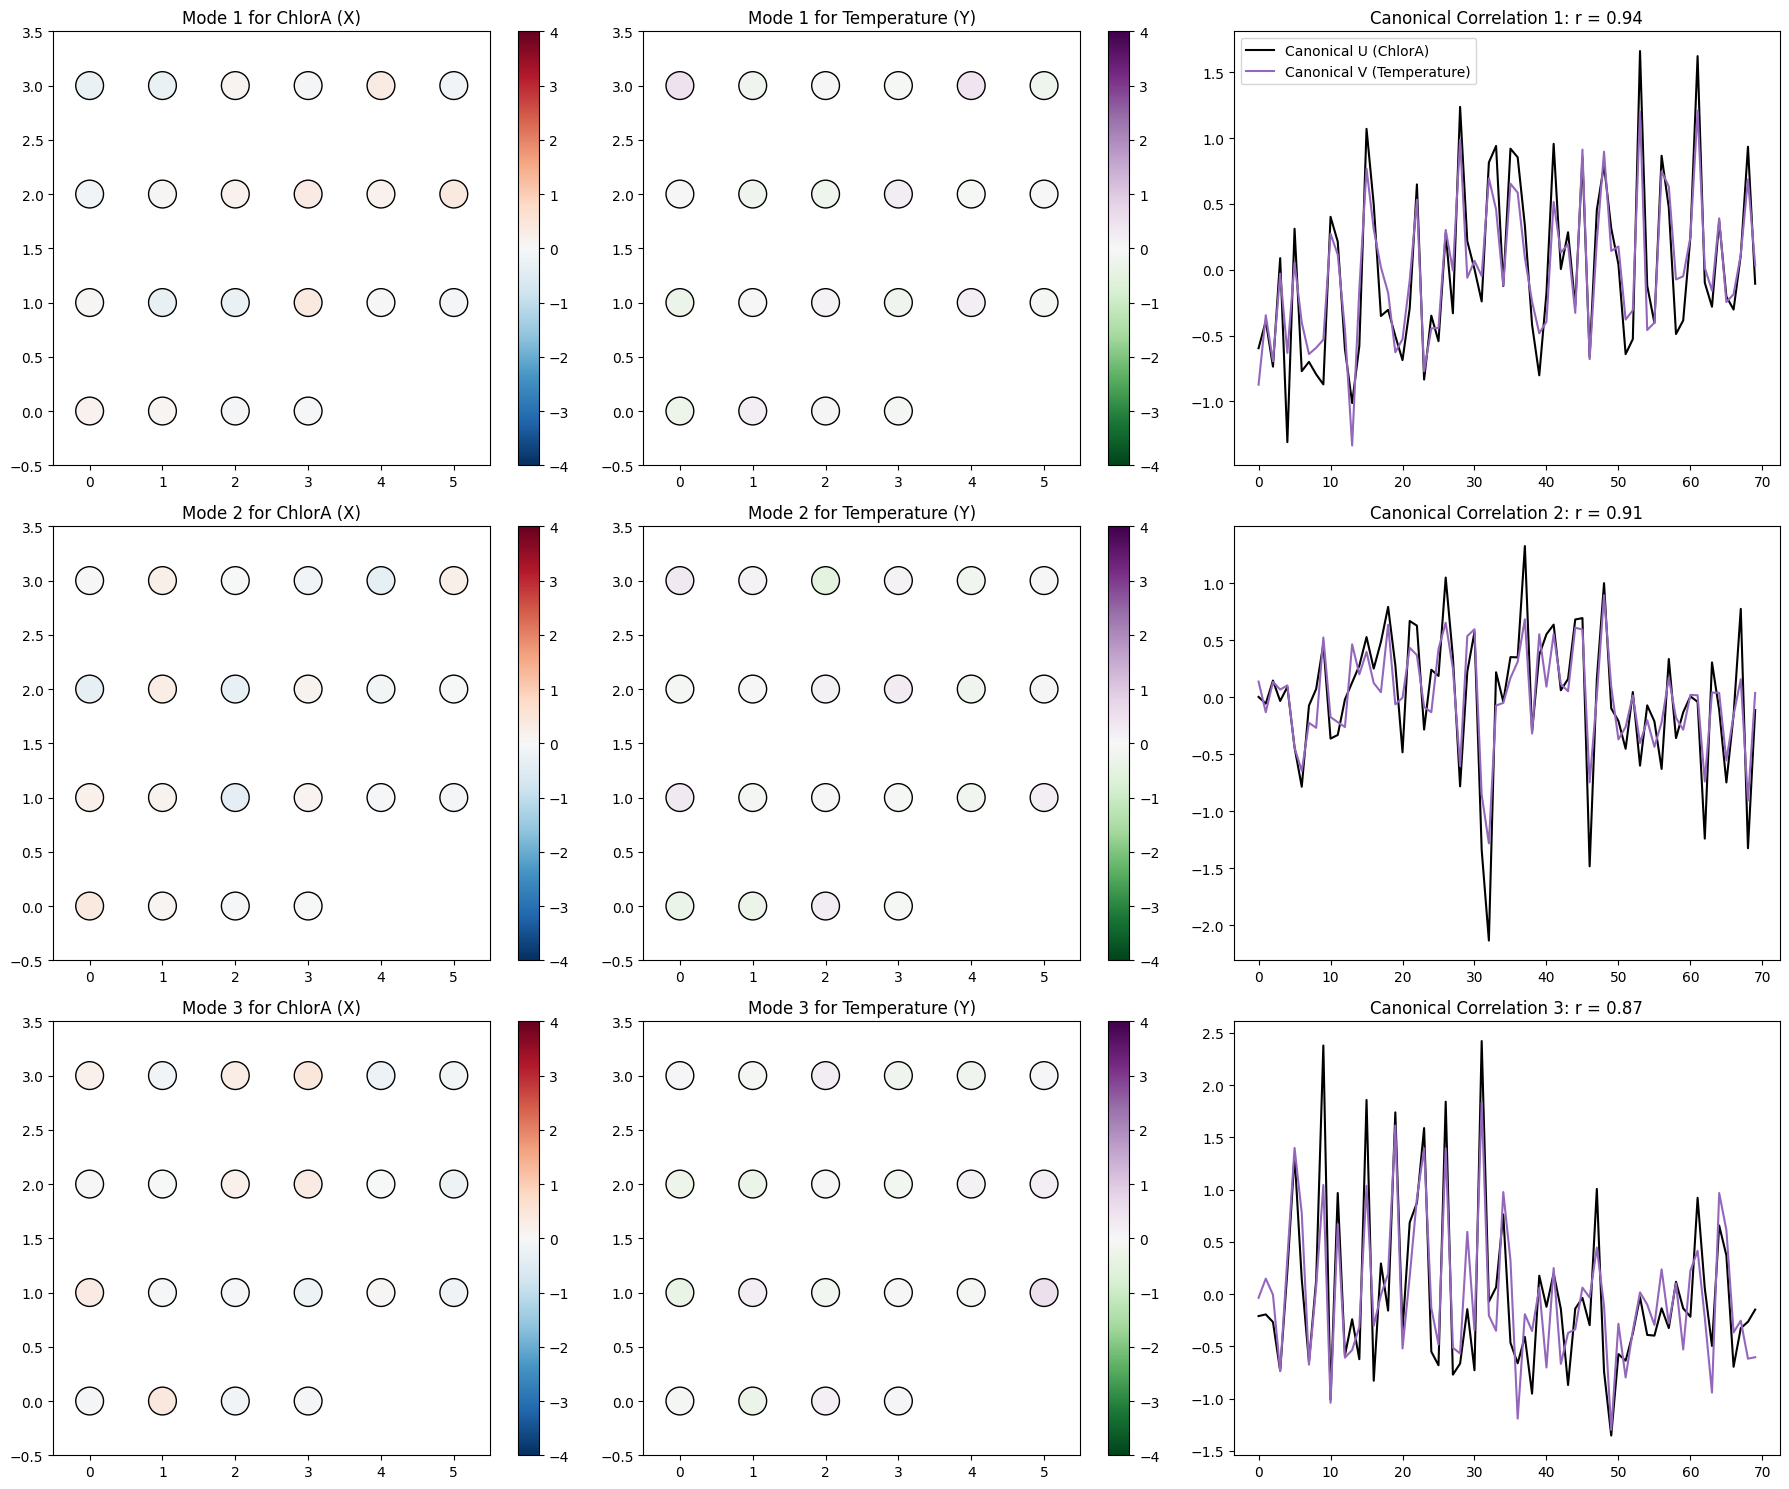

In [77]:
# Align the DataFrames so they have the same index and columns
common_index = cal_data_pivot.index.intersection(temp_data_pivot.index)
common_columns = cal_data_pivot.columns.intersection(temp_data_pivot.columns)

cal_data_aligned = cal_data_pivot.loc[common_index, common_columns]
temp_data_aligned = temp_data_pivot.loc[common_index, common_columns]

# Ensure data is aligned and contains no missing values
cal_data_aligned = cal_data_aligned.dropna()
temp_data_aligned = temp_data_aligned.dropna()

# Convert to numpy arrays for CCA
X = cal_data_aligned.values
Y = temp_data_aligned.values

# Perform CCA with a suitable number of components
n_components = min(X.shape[1], Y.shape[1])
cca = CCA(n_components=n_components)
U, V = cca.fit_transform(X, Y)

# Prepare to plot up to 6 modes or as many as available
n_modes = min(3, n_components)
fig, ax = plt.subplots(n_modes, 3, figsize=(18, 5 * n_modes))

for i in range(n_modes):
    # Plot X mode vector (A)
    out = ax[i, 0].scatter(
        np.arange(X.shape[1]) % 6,  # Set a 4x6 grid layout for the 22 stations
        3 - np.arange(X.shape[1]) // 6,
        c=cca.x_weights_[:, i],
        s=400,  # Adjust the size of the circles as needed
        cmap="RdBu_r",
        edgecolors="k",
        vmin=-4,
        vmax=4
    )
    ax[i, 0].set_ylim(-0.5, 3.5)
    ax[i, 0].set_xlim(-0.5, 5.5)
    ax[i, 0].set_title(f"Mode {i+1} for ChlorA (X)")
    plt.colorbar(out, ax=ax[i, 0])

    # Plot Y mode vector (B)
    out = ax[i, 1].scatter(
        np.arange(Y.shape[1]) % 6,
        3 - np.arange(Y.shape[1]) // 6,
        c=cca.y_weights_[:, i],
        s=400,  # Adjust the size of the circles as needed
        cmap="PRGn_r",
        edgecolors="k",
        vmin=-4,
        vmax=4
    )
    ax[i, 1].set_ylim(-0.5, 3.5)
    ax[i, 1].set_xlim(-0.5, 5.5)
    ax[i, 1].set_title(f"Mode {i+1} for Temperature (Y)")
    plt.colorbar(out, ax=ax[i, 1])

    # Plot U and V (canonical variables)
    ax[i, 2].plot(U[:, i], label="Canonical U (ChlorA)", c="k")
    ax[i, 2].plot(V[:, i], label="Canonical V (Temperature)", c="C4")
    r = np.corrcoef(U[:, i], V[:, i])[0, 1]
    ax[i, 2].set_title(f"Canonical Correlation {i+1}: r = {round(r, 2)}")

    if i == 0:
        ax[i, 2].legend()

plt.tight_layout()
plt.show()

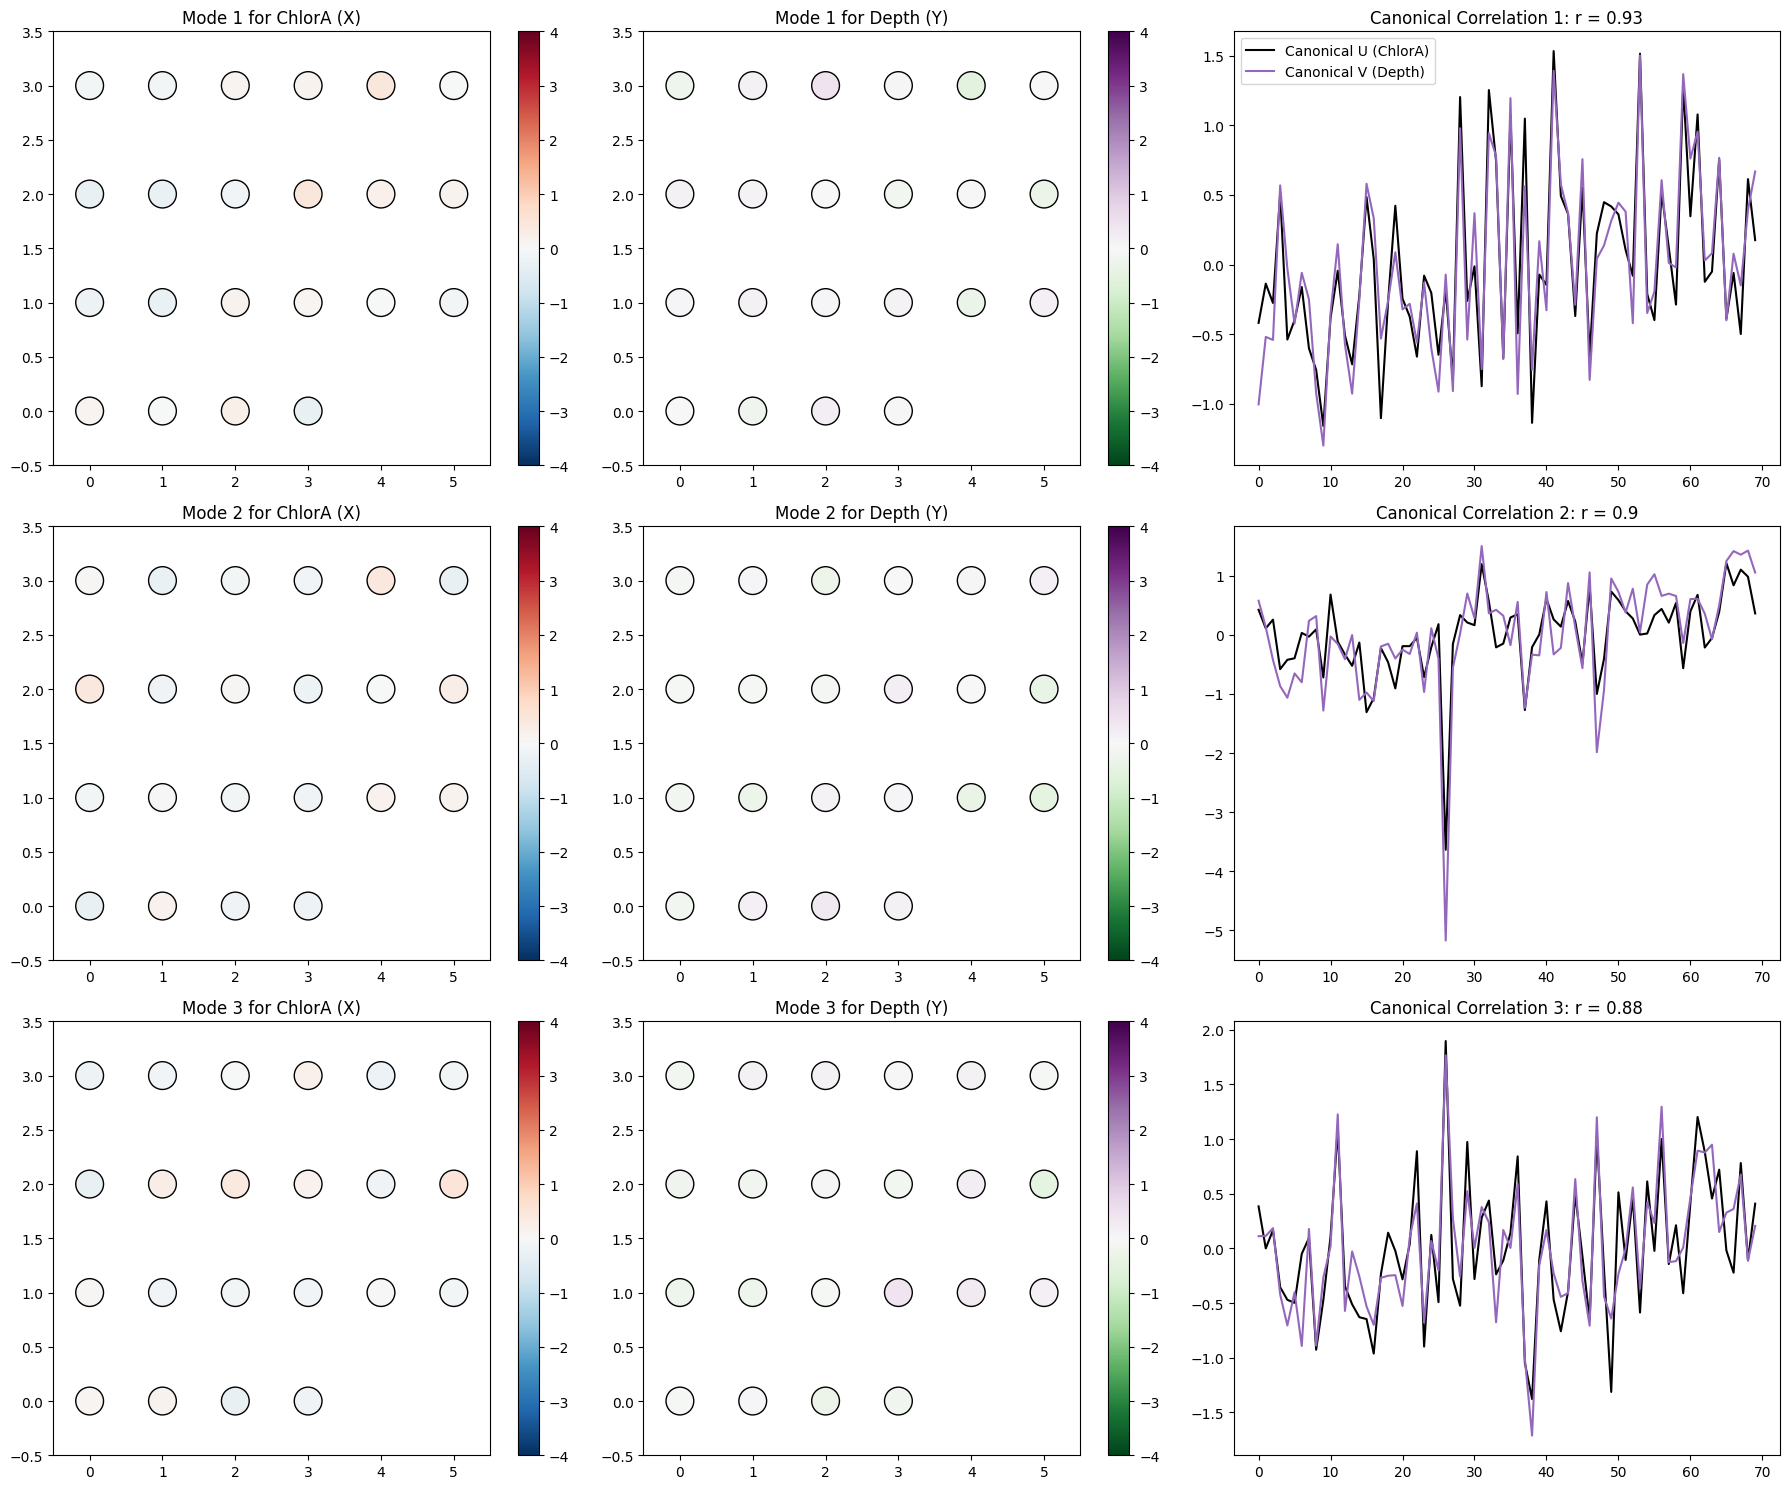

In [75]:
# Align the DataFrames so they have the same index and columns
common_index = cal_data_pivot.index.intersection(depth_data_pivot.index)
common_columns = cal_data_pivot.columns.intersection(depth_data_pivot.columns)

cal_data_aligned = cal_data_pivot.loc[common_index, common_columns]
depth_data_aligned = depth_data_pivot.loc[common_index, common_columns]

# Ensure data is aligned and contains no missing values
cal_data_aligned = cal_data_aligned.dropna()
depth_data_aligned = depth_data_aligned.dropna()

# Convert to numpy arrays for CCA
X = cal_data_aligned.values
Y = depth_data_aligned.values

# Perform CCA with a suitable number of components
n_components = min(X.shape[1], Y.shape[1])
cca = CCA(n_components=n_components)
U, V = cca.fit_transform(X, Y)

# Prepare to plot up to 6 modes or as many as available
n_modes = min(3, n_components)
fig, ax = plt.subplots(n_modes, 3, figsize=(18, 5 * n_modes))

for i in range(n_modes):
    # Plot X mode vector (A)
    out = ax[i, 0].scatter(
        np.arange(X.shape[1]) % 6,  # Set a 4x6 grid layout for the 22 stations
        3 - np.arange(X.shape[1]) // 6,
        c=cca.x_weights_[:, i],
        s=400,  # Adjust the size of the circles as needed
        cmap="RdBu_r",
        edgecolors="k",
        vmin=-4,
        vmax=4
    )
    ax[i, 0].set_ylim(-0.5, 3.5)
    ax[i, 0].set_xlim(-0.5, 5.5)
    ax[i, 0].set_title(f"Mode {i+1} for ChlorA (X)")
    plt.colorbar(out, ax=ax[i, 0])

    # Plot Y mode vector (B)
    out = ax[i, 1].scatter(
        np.arange(Y.shape[1]) % 6,
        3 - np.arange(Y.shape[1]) // 6,
        c=cca.y_weights_[:, i],
        s=400,  # Adjust the size of the circles as needed
        cmap="PRGn_r",
        edgecolors="k",
        vmin=-4,
        vmax=4
    )
    ax[i, 1].set_ylim(-0.5, 3.5)
    ax[i, 1].set_xlim(-0.5, 5.5)
    ax[i, 1].set_title(f"Mode {i+1} for Depth (Y)")
    plt.colorbar(out, ax=ax[i, 1])

    # Plot U and V (canonical variables)
    ax[i, 2].plot(U[:, i], label="Canonical U (ChlorA)", c="k")
    ax[i, 2].plot(V[:, i], label="Canonical V (Depth)", c="C4")
    r = np.corrcoef(U[:, i], V[:, i])[0, 1]
    ax[i, 2].set_title(f"Canonical Correlation {i+1}: r = {round(r, 2)}")

    if i == 0:
        ax[i, 2].legend()

plt.tight_layout()
plt.show()